# SVM  para detección de fracturas


**Objetivo:** Clasificación de imágenes de fracturas.

Concrete surface cracks are major defect in civil structures. Building Inspection which is done for the evaluation of rigidity and tensile strength of the building. Crack detection plays a major role in the building inspection, finding the cracks and determining the building health.


https://www.kaggle.com/arunrk7/surface-crack-detection

**Información de las características**
The datasets contains images of various concrete surfaces with and without crack. The image data are divided into two as negative (without crack) and positive (with crack) in separate folder for image classification.


**Número de instancias:** 20000

# 1. Acceso a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Importando librerías

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
import cv2
import matplotlib.pyplot as plt
import random
import os
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import seaborn as sns

# 3. Lectura del archivo de rasgos del dataset de fracturas

In [ ]:
path = r"/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.7 Máquinas de soporte vectorial"
file = 'Crack_detection.csv'

In [ ]:
crackdf = pd.read_csv(os.path.join(path,file))
crackdf.head()

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,histogram_30,histogram_31,histogram_32,histogram_33,histogram_34,histogram_35,histogram_36,histogram_37,histogram_38,histogram_39,...,histogram_493,histogram_494,histogram_495,histogram_496,histogram_497,histogram_498,histogram_499,histogram_500,histogram_501,histogram_502,histogram_503,histogram_504,histogram_505,histogram_506,histogram_507,histogram_508,histogram_509,histogram_510,histogram_511,hal_0,hal_1,hal_2,hal_3,hal_4,hal_5,hal_6,hal_7,hal_8,hal_9,hal_10,hal_11,hal_12,hum_0,hum_1,hum_2,hum_3,hum_4,hum_5,hum_6,label
0,0.0,0.0,0.000344,0.001291,0.077696,0.996494,0.030928,0.000344,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003092,14.340574,0.919141,88.685637,0.327834,339.446535,340.401973,6.186158,8.956572,0.000663,2.957264,-0.283463,0.971165,0.000983,6.242072e-12,2.233073e-13,1.041450e-13,4.950733e-27,-1.960336e-19,1.509080e-26,Negative
1,0.0,0.0,0.000000,0.000000,0.000677,0.018131,0.999805,0.007771,0.0,0.0,0.000000,0.000000,0.000299,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009083,6.269218,0.935110,48.349401,0.474172,408.107500,187.128388,5.577430,7.687455,0.001040,2.412241,-0.332115,0.973919,0.000818,1.463855e-11,5.901619e-16,2.341292e-15,-8.468643e-31,-1.320266e-21,-2.618594e-30,Negative
2,0.0,0.0,0.000056,0.001782,0.015817,0.738533,0.674014,0.004678,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001499,38.125101,0.873469,150.681870,0.230239,373.582005,564.602381,6.572369,10.057244,0.000392,3.638398,-0.210553,0.946953,0.000889,5.087013e-11,5.778453e-14,4.986756e-14,2.659349e-27,-2.870814e-19,3.060799e-28,Negative
3,0.0,0.0,0.000493,0.001287,0.004766,0.806302,0.591442,0.000137,0.0,0.0,0.000027,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003741,15.243276,0.901027,77.006080,0.351366,372.144798,292.781043,6.020462,8.749902,0.000717,2.946216,-0.269856,0.963752,0.000896,9.388030e-11,6.772193e-14,4.243252e-14,2.129421e-28,-1.212230e-19,2.264652e-27,Negative
4,0.0,0.0,0.000000,0.000159,0.025533,0.904715,0.425195,0.001748,0.0,0.0,0.000000,0.000583,0.006728,0.000185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001746,34.652607,0.866670,129.983797,0.233556,358.956477,485.282581,6.440047,9.876679,0.000443,3.580773,-0.202915,0.939227,0.000929,3.757248e-11,5.387301e-14,1.404452e-13,2.203156e-27,-8.596433e-19,1.201618e-26,Negative


# 4. Exploración de imágenes

In [ ]:
crackdf.shape

(40000, 533)

In [ ]:
clases = crackdf.iloc[:,-1].unique()
n_clases = len(clases)
print(clases)

['Negative' 'Positive']


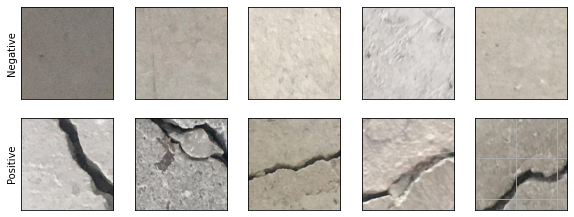

(227, 227, 3)


In [ ]:
path_img = r"/content/drive/MyDrive/Kaggle"
plt.figure(figsize=(20,20))
for i,folder in enumerate(clases):
    path_folder = os.path.join(path_img, folder)
    imgs_list =os.listdir(path_folder)
    random.shuffle(imgs_list)
    for j in range(5):
        img_path = os.path.join(path_folder,imgs_list[j])
        plt.subplot(10,10,i*10+j+1)
        img = plt.imread(img_path)
        plt.imshow(img)
        #plt.axis("off")
        plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
        if j==0:
            plt.ylabel(folder)
plt.grid('off')
plt.show()
print(img.shape)

# 5. Escalamiento y codificación

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
crackdf.loc[:, crackdf.columns != 'label'] = scaler.fit_transform(crackdf.loc[:, crackdf.columns != 'label'])

In [ ]:
le = LabelEncoder()
crackdf['label'] = le.fit_transform(crackdf.label.values)

In [ ]:
crackdf.describe()

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,histogram_30,histogram_31,histogram_32,histogram_33,histogram_34,histogram_35,histogram_36,histogram_37,histogram_38,histogram_39,...,histogram_492,histogram_493,histogram_494,histogram_495,histogram_496,histogram_497,histogram_498,histogram_499,histogram_500,histogram_501,histogram_502,histogram_503,histogram_504,histogram_505,histogram_506,histogram_507,histogram_508,histogram_509,histogram_510,histogram_511,hal_0,hal_1,hal_2,hal_3,hal_4,hal_5,hal_6,hal_7,hal_8,hal_9,hal_10,hal_11,hal_12,hum_0,hum_1,hum_2,hum_3,hum_4,hum_5,hum_6
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.006446,0.025277,0.013419,0.039918,0.136615,0.495057,0.399745,0.036011,0.008152,0.011096,0.017190,0.016259,0.037658,0.102623,0.044889,0.001627,0.005138,0.015419,0.005607,0.002226,0.000747,0.000333,0.000156,0.000135,0.004710,0.007922,0.001657,0.000161,0.000087,0.000101,0.000057,0.000132,0.003922,0.003228,0.000628,0.000028,0.000087,0.000078,0.000039,0.000049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004765,0.113847,0.866409,0.153439,0.278757,0.560657,0.151540,0.719001,0.712237,0.169132,0.580425,0.528514,0.920636,0.192116,0.016609,0.005549,0.004202,0.012127,0.377995,0.702670
std,0.032542,0.056901,0.033519,0.136599,0.246304,0.401842,0.395190,0.123368,0.043315,0.030508,0.040280,0.065673,0.120002,0.246791,0.162870,0.022687,0.027421,0.051831,0.024826,0.017687,0.013498,0.010583,0.007714,0.009178,0.025103,0.039400,0.016710,0.005740,0.006655,0.008449,0.007076,0.009300,0.023007,0.024087,0.016834,0.005004,0.008515,0.007010,0.005683,0.006782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006661,0.108425,0.102904,0.169663,0.106641,0.123916,0.168699,0.099990,0.107496,0.080000,0.120522,0.118999,0.078198,0.087407,0.041843,0.016527,0.014471,0.007116,0.009074,0.004785
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.002272,0.049820,0.024595,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

# 6. Reducción de dimensionalidad PCA

In [ ]:
pca = PCA(0.95)
pc = pca.fit_transform(crackdf.iloc[:,:-1])
df_pca = pd.DataFrame(data = pc,
                           columns=range(pc.shape[1]))
df_pca= pd.concat([df_pca, crackdf[['label']]], axis = 1)
print(df_pca.shape)

(40000, 31)


In [ ]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,label
0,-0.497054,-0.121356,-0.427997,0.062129,0.035574,0.024613,0.020352,-0.001463,0.020520,-0.039867,0.012487,-0.036508,0.013983,0.002378,0.008877,0.015151,0.007249,-0.006721,0.008519,0.027699,-0.024360,0.004600,0.019833,-0.009481,-0.006809,-0.020113,-0.017645,0.011665,-0.007505,-0.014278,0
1,0.878671,-0.058443,-0.122420,-0.057705,0.071530,-0.076755,0.044702,-0.060895,0.000846,0.039747,0.031307,0.024320,0.027735,-0.012046,0.025471,0.003887,-0.003713,-0.002589,-0.007274,0.011844,0.012564,-0.022809,0.004914,0.004104,-0.008420,-0.032339,-0.005407,-0.002655,-0.010083,-0.011362,0
2,0.053600,-0.363574,-0.184544,-0.042688,-0.345773,-0.008800,-0.050644,-0.035935,0.028689,-0.061982,-0.037330,-0.042019,-0.021246,0.038432,0.008145,0.005214,0.028108,-0.002459,0.021356,0.005808,-0.011734,0.018676,0.007025,-0.028209,0.019686,0.007455,-0.005247,0.008303,-0.001362,0.000584,0
3,0.034336,-0.329119,-0.333816,0.021942,-0.075303,-0.046566,0.012642,-0.070431,0.015842,-0.023984,-0.042954,0.002591,-0.012638,0.016373,-0.001167,-0.004347,0.009602,-0.006779,0.016133,-0.007654,0.000969,0.007320,0.006328,-0.015945,0.019235,0.017351,0.000843,0.000378,-0.001107,0.006460,0
4,-0.216112,-0.312805,-0.296605,-0.005547,-0.306655,0.024153,-0.033556,-0.013650,0.033888,-0.040586,-0.054125,-0.038475,-0.024571,0.034441,0.008683,0.009322,0.016736,-0.000724,0.017607,0.008613,-0.018002,0.020057,0.008738,-0.021922,0.011825,0.007201,-0.010732,0.012373,-0.002085,-0.003709,0


Poder explicativo:

In [ ]:
print('Número de componentes principales: %s'%len(pca.explained_variance_ratio_))
print('Varianza acumulada con %s componentes: %s'%(len(pca.explained_variance_ratio_),np.sum(pca.explained_variance_ratio_)))

Número de componentes principales: 30
Varianza acumulada con 30 componentes: 0.9515059498191749


# 7. Máquina de soporte vectorial para clasificación

In [ ]:
X = df_pca.iloc[:,:-1].to_numpy()
print(X.shape)

(40000, 30)


In [ ]:
y = df_pca.iloc[:,-1].to_numpy()
print(y.shape)

(40000,)


In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    plt.show()

In [ ]:
seed = 2

In [ ]:
svm =  SVC(random_state=seed)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

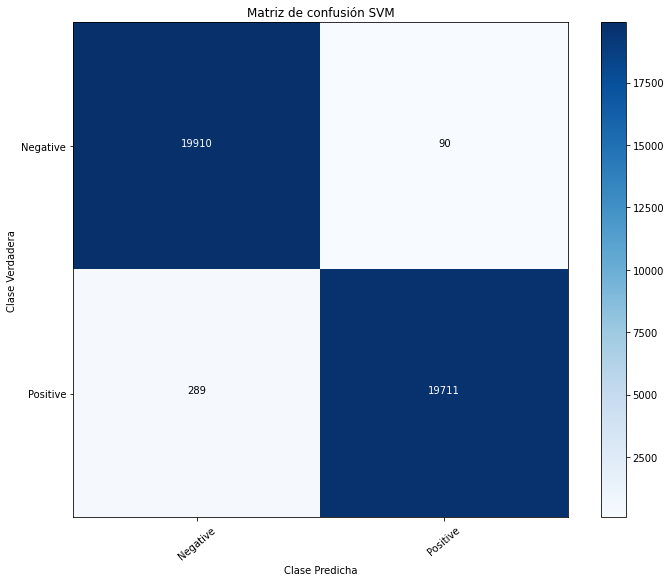

In [ ]:
score = cross_val_score(svm, X, y, cv=kfold, scoring="accuracy")
y_pred = cross_val_predict(svm, X, y, cv=10)

predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión SVM'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

In [ ]:
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

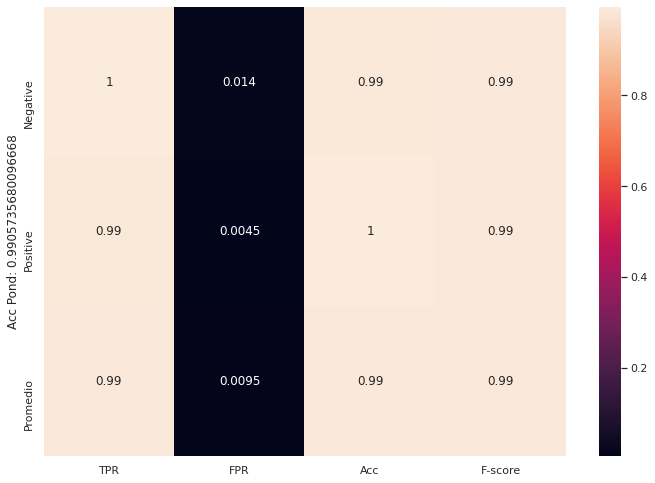

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, [0.5, 0.5])
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases.tolist()+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom=prec[0]*0.5+prec[1]*0.5
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)